---
title: "Occurence Rate"
---

## Setup

#### Import libraries

In [1]:
from fastcore.utils import patch
from fastcore.test import *

from ids_finder.utils.basic import load_catalog
from ids_finder.utils.basic import filter_tranges_df
from ids_finder.utils.analysis import filter_before_jupiter
from ids_finder.utils.analysis import link_coord2dim
from ids_finder.datasets import cIDsDataset

from beforerr.basics import pmap
from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects

from datetime import timedelta

import polars as pl
import polars.selectors as cs
import pandas as pd

import warnings

# This will filter out all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

04-Dec-23 09:02:03 INFO     04-Dec-23 09:02:03: cffi mode is CFFI_MODE.ANY                          ]8;id=274072;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/situation.py\situation.py]8;;\:]8;id=147801;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/situation.py#41\41]8;;\

                   INFO     04-Dec-23 09:02:03: R home found:                                      ]8;id=842496;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/situation.py\situation.py]8;;\:]8;id=726959;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/situation.py#218\218]8;;\
                            /Library/Frameworks/R.framework/Resources                                              

                   INFO     04-Dec-23 09:02:03: R library path:                                    ]8;id=473453;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/situation.py\situation.py]8;;\:]8;id=692154;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/situation.py#161\161]8;;\

                   INFO     04-Dec-23 09:02:03: LD_LIBRARY_PATH:                                   ]8;id=700389;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/situation.py\situation.py]8;;\:]8;id=825836;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/situation.py#165\165]8;;\

                   INFO     04-Dec-23 09:02:03: Default options to initialize R: rpy2, --quiet,      ]8;id=302267;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/embedded.py\embedded.py]8;;\:]8;id=632393;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/embedded.py#20\20]8;;\
                            --no-save                                                                              

                   INFO     04-Dec-23 09:02:03: R is already initialized. No need to initialize.    ]8;id=868454;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/embedded.py\embedded.py]8;;\:]8;id=402851;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/embedded.py#269\269]8;;\

In [2]:
catalog = load_catalog()

[12/04/23 09:02:04] WARNING  /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/ke ]8;id=323144;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=17762;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             dro_datasets/polars/lazy_polars_dataset.py:14: KedroDeprecationWarning:               
                             'AbstractVersionedDataSet' has been renamed to                                        
                             'AbstractVersionedDataset', and the alias will be removed in Kedro                    
                             0.19.0                                                                                
                               from kedro.io.core import (                                                         
                                                                                                                   

Connect `python` with `R` kernel

In [3]:
%load_ext rpy2.ipython

r = robjects.r
r.source('utils.R')

conv_pl = py2rpy_polars()

[12/04/23 09:02:05] WARNING  R[write to console]:                                                  ]8;id=667615;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=596587;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                             Attaching package: ‘dplyr’                                                            
                                                                                                                   
                                                                                                                   

                    WARNING  R[write to console]: The following objects are masked from            ]8;id=59068;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=156753;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                             ‘package:stats’:                                                                      
                                                                                                                   
                                 filter, lag                                                                       
                                                                                                                   
                                                                                                                   

                    WARNING  R[write to console]: The following objects are masked from            ]8;id=636062;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=688009;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                             ‘package:base’:                                                                       
                                                                                                                   
                                 intersect, setdiff, setequal, union                                               
                                                                                                                   
                                                                                                                   

### Loading all datasets from different sources

In [4]:
STA_ds = cIDsDataset(sat_id="STA", tau=60, ts=1, catalog=catalog)
JNO_ds = cIDsDataset(sat_id="JNO", tau=60, ts=1, catalog=catalog)
THB_ds = cIDsDataset(sat_id="THB", tau=60, ts=1, catalog=catalog)
Wind_ds = cIDsDataset(sat_id="Wind", tau=60, ts=1, catalog=catalog)

                    INFO     Loading data from 'events.STA_ts_1s_tau_60s'                       ]8;id=373570;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=351524;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'STA.MAG.primary_data_ts_1s'                     ]8;id=982678;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=745200;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'events.JNO_ts_1s_tau_60s'                       ]8;id=642524;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=692918;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'JNO.MAG.primary_data_ts_1s'                     ]8;id=822912;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=975272;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'events.THB_ts_1s_tau_60s'                       ]8;id=49196;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=585560;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'THB.MAG.primary_data_ts_1s'                     ]8;id=745422;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=615054;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'events.Wind_ts_1s_tau_60s'                      ]8;id=797134;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=67644;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'Wind.MAG.primary_data_ts_1s'                    ]8;id=956678;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=680486;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

ARTEMIS missions needs additional care as they are not always in the solar wind.

In [5]:
thb_inter_state_sw: pl.LazyFrame = catalog.load('THB.STATE.inter_data_sw')
start, end = thb_inter_state_sw.select(['start', 'end']).collect()

THB_sw_ds = cIDsDataset(
    sat_id="THB", tau=60, ts=1, catalog=catalog,
    candidates = filter_tranges_df(THB_ds.candidates, (start, end)), 
    data = filter_tranges_df(THB_ds.data.collect(), (start, end)).lazy()
)

THB_sw_ds = THB_ds.copy(
    update=dict(
        candidates = THB_ds.candidates.pipe(filter_tranges_df, (start, end)),
        data = THB_ds.data.collect().pipe(filter_tranges_df, (start, end)).lazy()
    )
)

                    INFO     Loading data from 'THB.STATE.inter_data_sw' (LazyPolarsDataset)... ]8;id=951871;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=995681;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [6]:
all_ds = [JNO_ds, Wind_ds, STA_ds, THB_sw_ds]

## Distance and Occurrence rates versus time for JUNO

In [7]:
def calc_or_df(events: pl.DataFrame, avg_window: timedelta, by=None):
    """Calculate the occurence rate of the candidates with the average window.

    Notes: occurence rate is defined as the number of candidates per day.
    """

    every = avg_window
    or_factor = every / timedelta(days=1)

    return (
        events.sort("time")
        .group_by_dynamic("time", every=every, by=by)
        .agg(
            cs.float().mean(),
            o_rates=pl.count() / or_factor
        )
        .upsample("time", every=every)  # upsample to fill the missing time
    )

In [8]:
df = JNO_ds.candidates.pipe(calc_or_df, timedelta(days=5))
%R -i df -c conv_pl

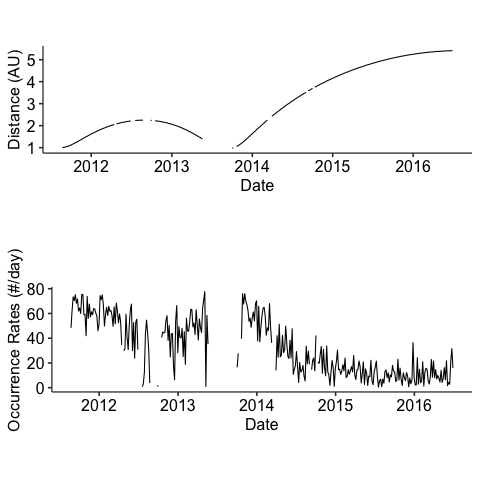

In [9]:
%%R
p1 <- ggplot(df, aes(x = time, y = radial_distance)) + 
  geom_line() + # Plot distance by date
  labs(x = "Date", y = "Distance (AU)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)
  
p2 <- ggplot(df, aes(x = time, y = o_rates)) + 
  geom_line() + # Plot distance by date
  labs(x = "Date", y = "Occurrence Rates (#/day)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)

p <- ggarrange(p1, p2, nrow = 2)

# save_plot("distance_and_or")
p

## Occurrence rates versus time for all missions

### Data normalization

Different levels of normalization are applied to the data. The normalization is done in the following order:

- `N1`: normalize the data by the the effective time of every duration due to the data gap as we may miss some potential IDs. We assume the data gap is independent of the magnetic discontinuities.
- `N2`: normalize the data by the mean value of data near 1 AU. This is to remove the effect of the temporal variation of the solar wind.

In [10]:
def calc_n1_factor(
    data: pl.LazyFrame,
    s_resolution: timedelta,
    l_resolution: timedelta,
):
    return (
        data.sort("time")
        .group_by_dynamic("time", every=s_resolution)
        .agg(pl.lit(1).alias("availablity"))
        .group_by_dynamic("time", every=l_resolution)
        .agg(n1_factor=pl.sum("availablity") * s_resolution / l_resolution)
    )


def n1_normalize(
    df: pl.DataFrame,  # the dataframe with count to be normalized
    data: pl.LazyFrame,  # the data used to calculate the duration ratio
    s_resolution,  # the smallest resolution to check if the data is available
    avg_window,
):
    duration_df = calc_n1_factor(data, s_resolution, avg_window).with_columns(
        cs.datetime().dt.cast_time_unit("ns"),
    )

    return df.lazy().join(duration_df, how="left", on="time").with_columns(
        o_rates_normalized=pl.col("o_rates") / pl.col("n1_factor")
    ).collect()
    
@patch
def calc_or_normalized(
    self: cIDsDataset, s_resolution: timedelta, avg_window: timedelta
):
    count_df = calc_or_df(self.candidates, avg_window)
    return n1_normalize(count_df, self.data, s_resolution, avg_window)

In [11]:
def n2_normalize(df: pl.DataFrame, avg_sats = ["STA", "THB", "Wind"]):
    avg_df = (
        df.filter(pl.col("sat").is_in(avg_sats))
        .group_by("time")
        .agg(n2_factor=pl.mean("o_rates_normalized"))
    )
    return df.join(avg_df, on="time").with_columns(
        o_rates_normalized=pl.col("o_rates_normalized") / pl.col("n2_factor")
    )

In [12]:
s_resolution = timedelta(minutes=1)
avg_window = timedelta(days=30)

In [13]:
all_events_or_N1: pl.DataFrame = pl.concat(
    all_ds
    | pmap(
        lambda x: x.calc_or_normalized(s_resolution, avg_window).with_columns(
            sat=pl.lit(x.sat_id)
        )
    ),
    how="diagonal",
)

In [14]:
all_events_or_N2 = all_events_or_N1.pipe(n2_normalize)

In [15]:
%%R
plot_or_time <- function(df) {
  p <- ggline(
    df, x = "time", y = "o_rates_normalized", 
    color = "sat", linetype = "sat") 
  
  p +   
    labs(x = "Date", y = "Occurrence Rates (#/day)", color="Satellites", linetype="Satellites") + 
    theme_pubr(base_size = 16) + 
    theme(legend.text = element_text(size=16)) +
    scale_color_okabeito(palette = "black_first")
}


[12/04/23 09:02:37] WARNING  R[write to console]: In addition:                                     ]8;id=701734;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=264887;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\

                    WARNING  R[write to console]: Warning message:                                 ]8;id=238729;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=625414;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                                                                                                                   

                    WARNING  R[write to console]: Removed 6 rows containing missing values         ]8;id=259220;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=399890;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                             (`geom_point()`).                                                                     
                                                                                                                   

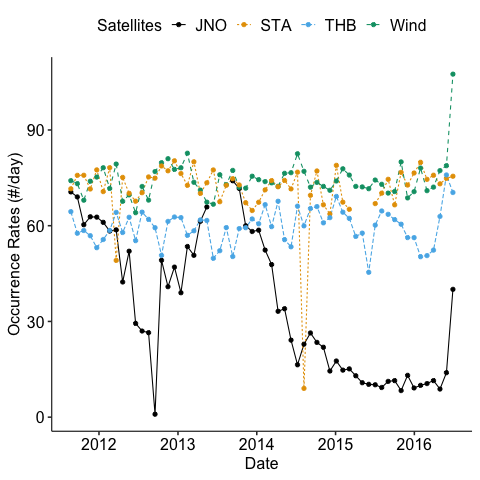

In [16]:
%%R -i all_events_or_N1 -c conv_pl
p <- plot_or_time(all_events_or_N1)
p

We noticed some anomalies in the occurrence rates of the magnetic discontinuities for Stereo-A data. Also for Juno, its occurrence rate is much higher when approaching Jupiter.

In [17]:
all_events_or_N1.filter(
    pl.col('time').is_in(pd.date_range('2014-01-01', '2015-01-01')),
    sat='STA'
)[["time", "o_rates", "o_rates_normalized", 'n1_factor']]

time,o_rates,o_rates_normalized,n1_factor
datetime[ns],f64,f64,f64
2014-01-10 00:00:00,64.466667,67.349278,0.957199
2014-02-09 00:00:00,71.2,71.232978,0.999537
2014-03-11 00:00:00,71.666667,74.137931,0.966667
2014-04-10 00:00:00,72.2,72.210029,0.999861
2014-05-10 00:00:00,74.166667,74.182121,0.999792
2014-06-09 00:00:00,65.733333,71.530265,0.918958
2014-07-09 00:00:00,68.233333,76.778496,0.888704
2014-08-08 00:00:00,4.033333,9.013968,0.447454
2014-09-07 00:00:00,11.0,69.53468,0.158194


Surprisingly, we found out that the anomaly of STEREO-A data is not mainly due to data gap. We can inspect this data further. See [appendix](#stereo-a-anomaly-during-2014-08-period).

We remove the intervals which do not have enough data points to calculate the normalized occurrence rates accurately and restrict the time range to exclude Jupiter's effect.

In [21]:
all_events_or_N1_cleaned = (
    all_events_or_N1.sort("time")
    .pipe(filter_before_jupiter)
    .filter(pl.col("o_rates") > 5)
    .upsample("time", every=avg_window, by="sat", maintain_order=True)
    .with_columns(pl.col("sat").forward_fill())
)

all_events_or_N2_cleaned = n2_normalize(all_events_or_N1_cleaned)

[12/04/23 09:07:11] WARNING  R[write to console]: In addition:                                     ]8;id=528510;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=609438;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\

                    WARNING  R[write to console]: Warning message:                                 ]8;id=128365;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=703585;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                                                                                                                   

                    WARNING  R[write to console]: Removed 9 rows containing missing values         ]8;id=944425;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=539810;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                             (`geom_point()`).                                                                     
                                                                                                                   

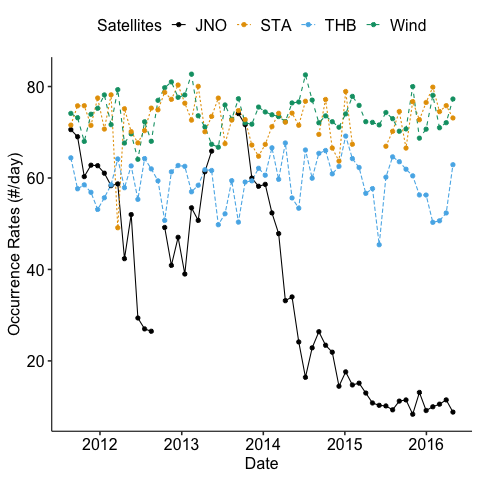

In [22]:
%%R -i all_events_or_N1_cleaned -c conv_pl
p <- plot_or_time(all_events_or_N1_cleaned)
# save_plot("ocr/ocr_time_cleaned")
p

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


[12/04/23 09:16:01] WARNING  R[write to console]: In addition:                                     ]8;id=677534;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=460660;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\

                    WARNING  R[write to console]: Warning message:                                 ]8;id=892667;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=811966;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                                                                                                                   

                    WARNING  R[write to console]: Removed 9 rows containing missing values         ]8;id=396682;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=351487;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                             (`geom_point()`).                                                                     
                                                                                                                   

In addition: Warning messages:
1: Removed 9 rows containing missing values (`geom_point()`). 
2: Removed 9 rows containing missing values (`geom_point()`). 


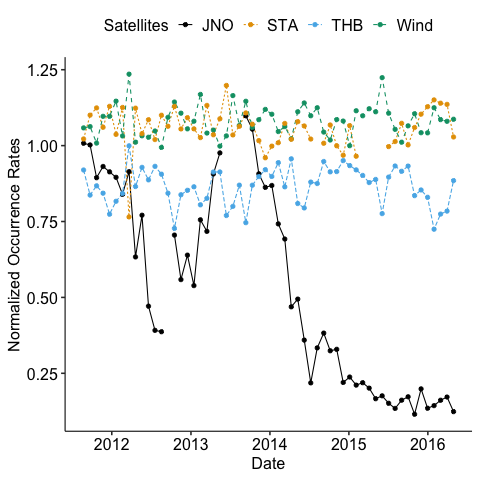

In [24]:
%%R -i all_events_or_N2_cleaned -c conv_pl
p <- plot_or_time(all_events_or_N2_cleaned)
p <- p + labs(y = "Normalized Occurrence Rates")
save_plot("ocr/ocr_time_N2_cleaned")
p

#### Plot the occurrence rates with radial distance


In [25]:
%%R
plot_or_r <- function(df, target_sat = "JNO") {
  "plot normalized occurrence rate over radial distance"
  
  # Filter data for target_sat
  df_target <- df[df$sat == target_sat,]
  
  # Compute the linear model
  fit <- lm(o_rates_normalized ~ I(1/ref_radial_distance), data = df_target)
  
  # Extract coefficients
  intercept <- coef(fit)[1]
  slope <- coef(fit)[2]
  
  # Format equation
  equation <- sprintf("y ~ %.2f / x", slope)
  
  p <- ggscatter(df, x = "ref_radial_distance", y = "o_rates_normalized", color = "sat") +
    geom_smooth(data = df_target, formula = y ~ I(1/x), method = "lm", color="gray", linetype="dashed")
    
  p <- p +
    labs(x = "Referred Radial Distance (AU)", y = "Occurrence Rate  (#/day)", color="Satellites") +
    annotate("text", label = equation, x = Inf, y = Inf, hjust = 1.1, vjust = 1.5, size = 7) +
    theme_pubr(base_size = 16) + 
    theme(legend.text = element_text(size=16)) +
    scale_color_okabeito(palette = "black_first")
  
  return(p)
}

In [26]:
df = link_coord2dim(all_events_or_N1_cleaned).sort("ref_radial_distance")

In addition: Warning messages:
1: Removed 4 rows containing non-finite values (`stat_smooth()`). 
2: Removed 21 rows containing missing values (`geom_point()`). 


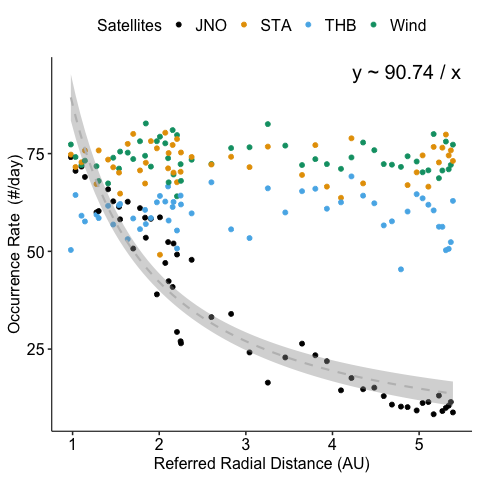

In [27]:
%%R -i df -c conv_pl
p <- plot_or_r(df)
print(p)
# save_plot("ocr_r_cleaned")

In [28]:
df = link_coord2dim(all_events_or_N2_cleaned).sort("ref_radial_distance")

In addition: Warning messages:
1: Removed 4 rows containing non-finite values (`stat_smooth()`). 
2: Removed 21 rows containing missing values (`geom_point()`). 


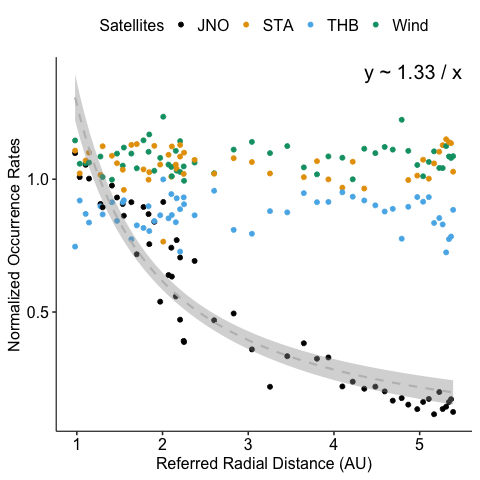

In [29]:
%%R -i df -c conv_pl
#| code-summary: R Code
p <- plot_or_r(df) + labs(y = "Normalized Occurrence Rates")
print(p)
# save_plot("ocr/ocr_r_N2_cleaned")

## Appendix

### Obsolete codes

Notes: `seaborn.lineplot` drops nans from the DataFrame before plotting, this is not desired...

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt
import scienceplots
from ids_finder.utils.plot import savefig

In [ ]:
plt.style.use(['science', 'nature', 'notebook'])

In [ ]:

def plot_or_r(df: pl.DataFrame):
    "plot normalized occurence rate over radial distance"

    sns.lineplot(x="ref_radial_distance", y="o_rates_normalized", hue="sat", data=df)

    ax = plt.gca()  # Get current axis
    ax.set_yscale("log")
    ax.set_xlabel("Referred Radial Distance (AU)")
    ax.set_ylabel("Normalized Occurrence Rate")
    # savefig('occurrence_rate_ratio')

    return ax.figure

In [ ]:
def plot_or_time(df: pl.DataFrame):
    """Plot the occurence rate of the candidates with time.    
    """
    # Create a unique list of all satellites and sort them to let JNO' be plotted first
    all_sats = df["sat"].unique().to_list()
    all_sats.sort(key=lambda x: x != "JNO")

    # Plot each satellite separately
    for sat in all_sats:
        sat_df = df.filter(sat=sat)
        if sat == "JNO":
            sns.lineplot(sat_df, x="time", y="o_rates_normalized", label=sat)
        else:
            # Making the other satellites more distinct with linestyle and alpha
            sns.lineplot(
                sat_df,
                x="time",
                y="o_rates_normalized",
                linestyle="--",  # dashed line style
                alpha=0.5,  # keep the order of the legend
                label=sat,
            )

    ax = plt.gca()  # Get current axis
    # Set the y-axis and x-axis labels
    ax.set_ylabel("Occurrence Rates (#/day)")
    ax.set_xlabel("Date")
    ax.legend(title="Satellites")

    # savefig("occurrence_rates")
    return ax.figure

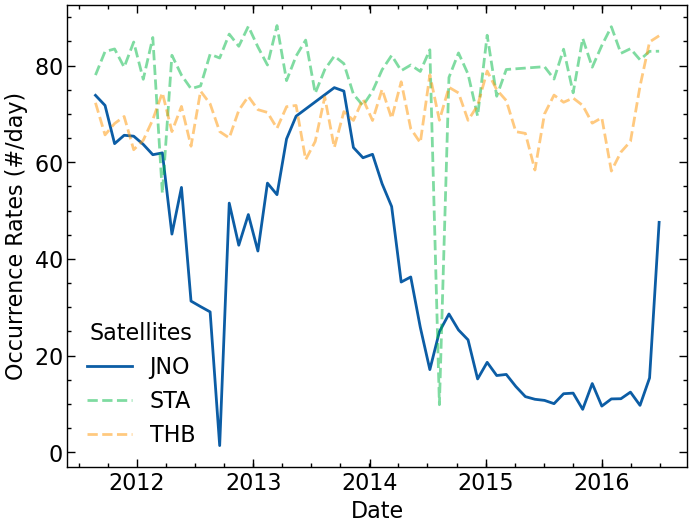

In [ ]:
fig = plot_or_time(
    all_events_or_N1
)

### STEREO-A anomaly during 2014-08 period

In [ ]:
mag: pl.DataFrame = catalog.load('sta.inter_mag_1s').filter(pl.col('B')>0).collect()

In [ ]:
import plotly.graph_objects as go;
from plotly_resampler import FigureResampler
import plotly.express as px

In [ ]:
# px.line(mag, x='time', y='B') # This is extremely slow for large datasets

fig = FigureResampler(go.Figure())
fig.add_trace({"x": mag["time"], "y": mag['B']})
fig